In [74]:
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox

from garmin_fit_sdk import Decoder, Stream
import gpxpy

import pytrack

import matplotlib.pyplot as plt

import os

In [7]:
G = ox.geocoder.geocode_to_gdf('North Delta, BC, Canada')
print(G.loc[0])

geometry        MULTIPOLYGON (((-122.9420911 49.1581506, -122....
bbox_west                                             -122.942091
bbox_south                                              49.102603
bbox_east                                             -122.890154
bbox_north                                              49.177145
place_id                                                349430221
osm_type                                                 relation
osm_id                                                   11693712
lat                                                     49.137883
lon                                                   -122.911231
class                                                    boundary
type                                               administrative
place_rank                                                     18
importance                                               0.160059
addresstype                                         city_district
name      

In [8]:
def in_bbox(lat, lng, gdf_row):
    return lat.between(gdf_row['bbox_south'],gdf_row['bbox_north']).any() and lng.between(gdf_row['bbox_west'],gdf_row['bbox_east']).any()

In [9]:
activities_df = pd.read_csv('strava_data/activities.csv',index_col=0)
activities_df = activities_df[activities_df['Activity Type'].isin(['Run','Walk'])]

routes = {}
j = 0
for i, row in activities_df.iterrows():
    if j%100 == 0:
        print(j)
    filename = 'strava_data/' + row['Filename'][:-3]
    # print(int(filename[23:25]))
    if os.path.isfile(filename):
        # handle .fit files
        if filename[-3:] == 'fit':
            stream = Stream.from_file(filename)
            decoder = Decoder(stream)
            messages,errors = decoder.read(convert_datetimes_to_dates=True)
            record = messages['record_mesgs']
            df = pd.DataFrame(record)
            try:
                df = df.set_index('timestamp')[['position_lat','position_long']]
            except:
                continue
            if in_bbox(df['position_lat']/(2**32/360),df['position_long']/(2**32/360),G.loc[0]):
                routes[i] = df
        # handle .gpx files
        elif filename[-3:] == 'gpx':
            with open(filename) as file:
                gpx = gpxpy.parse(file)
            
            points = []
            for segment in gpx.tracks[0].segments:
                for point in segment.points:
                    points.append({
                        'timestamp' : point.time,
                        'lat' : point.latitude,
                        'lng' : point.longitude
                    })
            df = pd.DataFrame.from_records(points)
            try:
                df = df.set_index('timestamp')
            except:
                continue
            if in_bbox(df['lat']/(2**32/360),df['lng']/(2**32/360),G.loc[0]):
                routes[i] = df
    j = j+1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200


In [10]:
df = pd.concat(routes.values(),keys=routes.keys())
df.to_csv('routes.csv',index_label=['activity_id','timestamp'])
df = pd.read_csv('routes.csv',index_col=['activity_id','timestamp'])

In [11]:
ox.settings.bidirectional_network_types=['walk','drive','all']

place = 'North Delta, BC, Canada'
with open('csquery.txt') as file:
    filter = file.readline()
gdf = ox.geocoder.geocode_to_gdf(place)
G = ox.graph.graph_from_place(place,retain_all=True,truncate_by_edge=True,custom_filter=filter,simplify=False)
polygon = ox.utils_geo.buffer_geometry(gdf.iloc[0]['geometry'],500)
H = ox.graph.graph_from_polygon(polygon,network_type='walk',retain_all=True,truncate_by_edge=True,simplify=False)


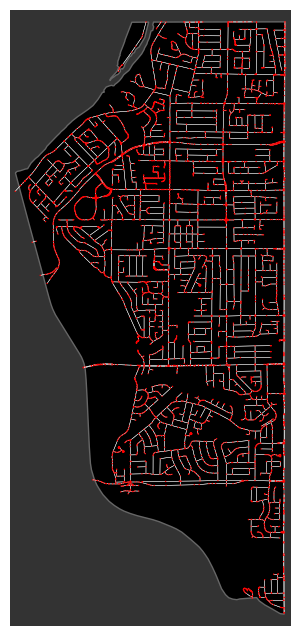

In [12]:

# plot the network, but do not show it or close it yet
fig, ax = ox.plot.plot_graph(
    G,
    show=False,
    close=False,
    bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0.3,
    node_size=1,
    node_color='r'
)

# to this matplotlib axis, add the place shape(s)
gdf.plot(ax=ax, fc="k", ec="#666666", lw=1, alpha=1, zorder=-1)
# optionally set up the axes extents
margin = 0.02
west, south, east, north = gdf.union_all().bounds
margin_ns = (north - south) * margin
margin_ew = (east - west) * margin
ax.set_ylim((south - margin_ns, north + margin_ns))
ax.set_xlim((west - margin_ew, east + margin_ew))
plt.show()


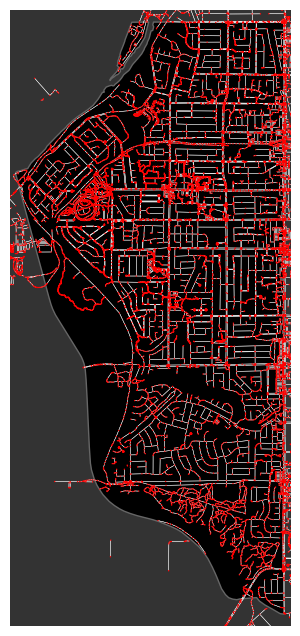

In [13]:

# plot the network, but do not show it or close it yet
fig, ax = ox.plot.plot_graph(
    H,
    show=False,
    close=False,
    bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0.3,
    node_size=1,
    node_color='r'
)

# to this matplotlib axis, add the place shape(s)
gdf.plot(ax=ax, fc="k", ec="#666666", lw=1, alpha=1, zorder=-1)
# optionally set up the axes extents
margin = 0.02
west, south, east, north = gdf.union_all().bounds
margin_ns = (north - south) * margin
margin_ew = (east - west) * margin
ax.set_ylim((south - margin_ns, north + margin_ns))
ax.set_xlim((west - margin_ew, east + margin_ew))
plt.show()


In [14]:
G_proj = ox.projection.project_graph(G)
ints_G = ox.simplification.consolidate_intersections(
    G_proj,rebuild_graph=True,tolerance=15,dead_ends=True
)
print(len(G))
print(len(ints_G))

5398
1873


In [15]:
H_proj = ox.projection.project_graph(H)
ints_H = ox.simplification.consolidate_intersections(
    H_proj,rebuild_graph=True,tolerance=5,dead_ends=True
)
print(len(H))
print(len(ints_H))

23799
10983


In [16]:
print(len(set(G.nodes)))
print(len(set(H.nodes)))
print(len(set(G.nodes) - set(H.nodes)))
print(len(set(H.nodes) - set(G.nodes)))
print('---')

edges_G = set(G.edges(keys=True))
edges_H = set(H.edges(keys=True))

print(len(edges_G))
print(len(edges_H))
print(len(edges_G - edges_H))
print(len(edges_H - edges_G))

5398
23799
838
19239
---
11342
51718
3188
43564


In [17]:
print(len(set(ints_G.nodes)))
print(len(set(ints_H.nodes)))
print(len(set(ints_G.nodes) - set(ints_H.nodes)))
print(len(set(ints_H.nodes) - set(ints_G.nodes)))
print('---')

edges_ints_G = set(ints_G.edges(keys=True))
edges_ints_H = set(ints_H.edges(keys=True))

print(len(edges_ints_G))
print(len(edges_ints_H))
print(len(edges_ints_G - edges_ints_H))
print(len(edges_ints_H - edges_ints_G))

1873
10983
0
9110
---
4254
25624
3304
24674


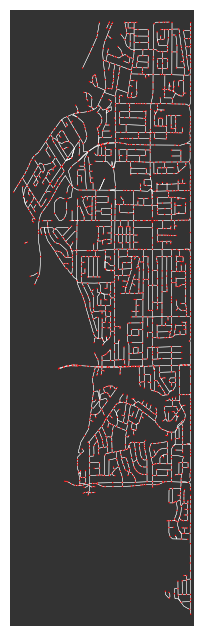

In [18]:
back_G = ox.projection.project_graph(ints_G,to_latlong=True)
# plot the network, but do not show it or close it yet
fig, ax = ox.plot.plot_graph(
    ints_G,
    show=False,
    close=False,
    bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0.3,
    node_size=1,
    node_color='r'
)

# to this matplotlib axis, add the place shape(s)
gdf.plot(ax=ax, fc="k", ec="#666666", lw=1, alpha=1, zorder=-1)
# optionally set up the axes extents
# margin = 0.02
# west, south, east, north = gdf.union_all().bounds
# margin_ns = (north - south) * margin
# margin_ew = (east - west) * margin
# ax.set_ylim((south - margin_ns, north + margin_ns))
# ax.set_xlim((west - margin_ew, east + margin_ew))
plt.show()


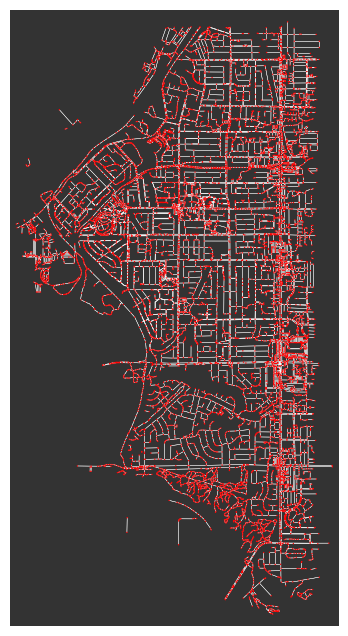

In [19]:

# plot the network, but do not show it or close it yet
fig, ax = ox.plot.plot_graph(
    ints_H,
    show=False,
    close=False,
    bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0.3,
    node_size=1,
    node_color='r'
)

# # to this matplotlib axis, add the place shape(s)
# gdf.plot(ax=ax, fc="k", ec="#666666", lw=1, alpha=1, zorder=-1)
# # optionally set up the axes extents
# margin = 0.02
# west, south, east, north = gdf.union_all().bounds
# margin_ns = (north - south) * margin
# margin_ew = (east - west) * margin
# ax.set_ylim((south - margin_ns, north + margin_ns))
# ax.set_xlim((west - margin_ew, east + margin_ew))
plt.show()


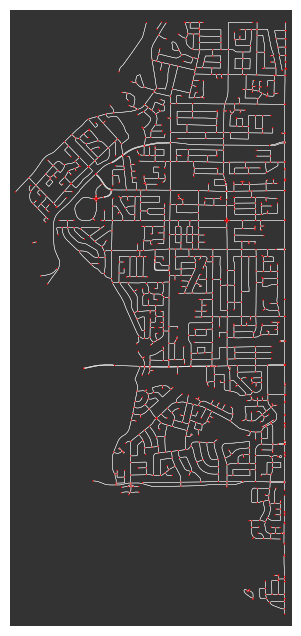

1243


In [20]:
G_simp = ox.simplification.simplify_graph(G)
fig, ax = ox.plot.plot_graph(
    G_simp,
    show=False,
    close=False,
    bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0.3,
    node_size=1,
    node_color='r'
)
plt.show()
print(len(G_simp))


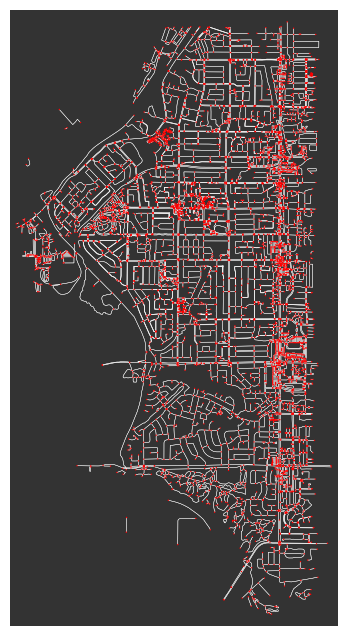

6876


In [21]:
H_simp = ox.simplification.simplify_graph(H)
fig, ax = ox.plot.plot_graph(
    H_simp,
    show=False,
    close=False,
    bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0.3,
    node_size=1,
    node_color='r'
)
plt.show()
print(len(H_simp))


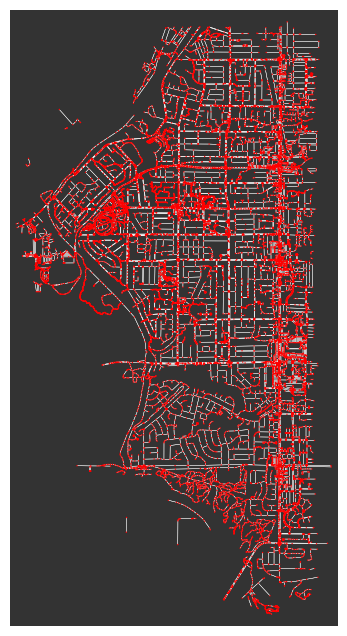

In [22]:
C = nx.compose(G,H)


# plot the network, but do not show it or close it yet
fig, ax = ox.plot.plot_graph(
    C,
    show=False,
    close=False,
    bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0.3,
    node_size=1,
    node_color='r'
)

# # to this matplotlib axis, add the place shape(s)
# gdf.plot(ax=ax, fc="k", ec="#666666", lw=1, alpha=1, zorder=-1)
# # optionally set up the axes extents
# margin = 0.02
# west, south, east, north = gdf.union_all().bounds
# margin_ns = (north - south) * margin
# margin_ew = (east - west) * margin
# ax.set_ylim((south - margin_ns, north + margin_ns))
# ax.set_xlim((west - margin_ew, east + margin_ew))
plt.show()


49.102672527852015 -122.95791915906044 49.204123058070245 -122.81981263932295


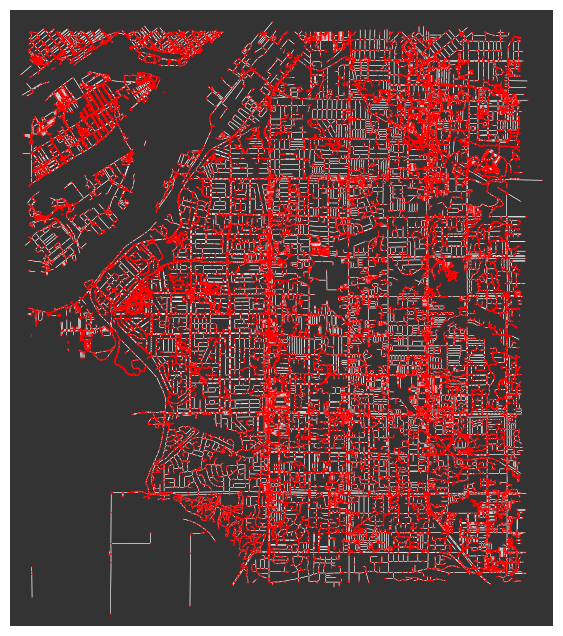

In [23]:
import pytrack.analytics
import pytrack.matching
import pytrack.matching.mpmatching
import pytrack.matching.mpmatching_utils
import logging

min_lat = None
max_lat = None
min_lng = None
max_lng = None

for df in routes.values():
    df = df/11930465
    if min_lat is None:
        min_lat = df['position_lat'].min()
        max_lat = df['position_lat'].max()
        min_lng = df['position_long'].min()
        max_lng = df['position_long'].max()
    
    if df['position_lat'].min() < min_lat:
        min_lat = df['position_lat'].min()
    if df['position_lat'].max() > max_lat:
        max_lat = df['position_lat'].max()
    if df['position_long'].min() < min_lng:
        min_lng = df['position_long'].min()
    if df['position_long'].max() > max_lng:
        max_lng = df['position_long'].max()

print(min_lat,min_lng,max_lat,max_lng)
H = ox.graph_from_bbox([max_lng,min_lat,min_lng,max_lat],network_type='walk',retain_all=True,truncate_by_edge=True,simplify=False)
C = nx.compose(G,H)


# plot the network, but do not show it or close it yet
fig, ax = ox.plot.plot_graph(
    C,
    show=False,
    close=False,
    bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0.3,
    node_size=1,
    node_color='r'
)

# # to this matplotlib axis, add the place shape(s)
# gdf.plot(ax=ax, fc="k", ec="#666666", lw=1, alpha=1, zorder=-1)
# # optionally set up the axes extents
# margin = 0.02
# west, south, east, north = gdf.union_all().bounds
# margin_ns = (north - south) * margin
# margin_ew = (east - west) * margin
# ax.set_ylim((south - margin_ns, north + margin_ns))
# ax.set_xlim((west - margin_ew, east + margin_ew))
plt.show()


In [59]:
import re

# df = pd.read_csv('routes.csv',index_col=['activity_id','timestamp'])
# print(df.isnull().values.sum())

with open('subgraph.txt') as file:
    subgraph_str = file.read()

subgraph_nodes = list(map(int,re.findall(r"[0-9]+",subgraph_str)))
print(sorted(subgraph_nodes))

subgraph = C.subgraph(subgraph_nodes).copy()
print(len(C))
print(len(subgraph))
print(sorted(C.nodes()))

[143154981, 149976537, 149976537, 507455743, 509060282, 509060282, 509060282, 509060282, 509060282, 509060282, 524335287, 524335287, 567067019, 567067019, 611592491, 611592491, 611592491, 611592491, 611592491, 611592491, 611592491, 611592491, 611592491, 611592491, 625066133, 625066133, 625066133, 625066133, 683065247, 683065247, 726606182, 726606182, 824739381, 850246474, 942384409, 942384409, 1123060251, 1263051421, 1263051421, 1263051421, 1263051421, 1263051421, 1263051421, 1367382384, 1367382384, 1421931211, 1585494366, 1837743415, 1837743415, 1871187925, 1871187925, 1871187925, 1871187925, 1989712752, 1989712752, 2104908669]
84427
0
[24657866, 24657870, 24658063, 25477554, 25477618, 25477619, 25477627, 25987877, 33365453, 39601515, 150227140, 150234804, 179207782, 179207795, 179207808, 221877152, 221877941, 250917418, 250917419, 250917420, 250917421, 250917422, 250917423, 250917425, 253623064, 254281778, 254282511, 254361841, 254361845, 254361846, 254361849, 254361850, 254361851, 2

In [165]:
paths = []
j = 0
for id,df in routes.items():
    print(j,'id:',id)
    if j < 43:
        j = j+1
        continue
    df = df/11930465
    df = df[df['position_lat'].notnull()]
    latitude = df['position_lat'].to_list()
    longitude = df['position_long'].to_list()

    points = [(lat, lng) for lat, lng in zip(latitude, longitude)]
    # print((df['position_lat'].mean(),df['position_long'].mean()))
    loc = (df['position_lat'].mean(),df['position_long'].mean())
    print('drawing graph')
    maps = pytrack.analytics.visualization.Map(location=loc)
    maps.add_graph(C, plot_nodes=True)
    # maps

    print('finding candidates')
    # print(C.keys())
    C_interp, candidates = pytrack.matching.candidate.get_candidates(C, points, interp_dist=0,closest=True,radius=50)
    # maps.draw_candidates(candidates,30)
    # maps

    print('filling missing candidates')
    for idx, (lat, lng) in enumerate(points):
        if idx not in(candidates.keys()):
            nearest,dist = ox.nearest_nodes(C,lng,lat,return_dist=True)
            edges = C.edges(nearest,data=True)
            edge_nodes = [node for edge in edges for node in edge[:2]]
            candidates[idx] = {"observation": (lat,lng),
                        "osmid": [nearest],
                        "edge_osmid": [edge[2]['osmid'] for edge in edges],
                        "candidates": [tuple([np.float64(C.nodes[node]['y']),np.float64(C.nodes[node]['x'])]) for node in edge_nodes],
                        "candidate_type": np.full(len(edge_nodes),False),
                        "dists": [dist]
            }

    print('creating trellis')
    trellis = pytrack.matching.mpmatching_utils.create_trellis(candidates)
    # print('drawing trellis')
    # trellis_draw = pytrack.analytics.visualization.draw_trellis(trellis,figsize=(150,120))
    print('performing matching')
    try:
        path_prob, pred = pytrack.matching.mpmatching.viterbi_search(C_interp,trellis)
    except:
        break
    print('saving path')
    paths.append(pytrack.matching.mpmatching_utils.create_path(C_interp,trellis,pred))

    j=j+1
# print('displaying trellis')
# trellis_draw

#     print('drawing path')
#     maps.draw_path(C_interp,trellis,pred)

# print('displaying map')
# maps


0 id: 2440482282
1 id: 2448416540
2 id: 2458899554
3 id: 2458930593
4 id: 2467276527
5 id: 2467299565
6 id: 2475717320
7 id: 2481145303
8 id: 2483924803
9 id: 2499515100
10 id: 2507594515
11 id: 2510444064
12 id: 2513619095
13 id: 2515749669
14 id: 2517956281
15 id: 2524219131
16 id: 2530070948
17 id: 2535531765
18 id: 2538893098
19 id: 2552575331
20 id: 2563101945
21 id: 2576621923
22 id: 2582138434
23 id: 2605636425
24 id: 2637282973
25 id: 2642326750
26 id: 2645410572
27 id: 2652013783
28 id: 2657968295
29 id: 2675057506
30 id: 2683765267
31 id: 2689137075
32 id: 2695097101
33 id: 2703717346
34 id: 2709301089
35 id: 2712689820
36 id: 2723768862
37 id: 2745088391
38 id: 2747960616
39 id: 2753074297
40 id: 2766172471
41 id: 2771301065
42 id: 2784180502
43 id: 2789147370
drawing graph
finding candidates
A total of 282 points has no candidates: (32, 33, 34, 87, 88, 106, 107, 111, 112, 124, 129, 130, 132, 133, 134, 142, 143, 144, 145, 146, 147, 148, 149, 150, 157, 158, 159, 160, 161, 162

In [113]:
print([len(c) for c in sorted(nx.weakly_connected_components(trellis))])

[3439]


In [212]:
test = candidates.copy()
connect = trellis.copy()
last = max(int(u_name.split('_')[0]) for u_name in connect.nodes() if u_name not in ('start','target'))

In [ ]:
print(len([c for c in sorted(nx.weakly_connected_components(C))]))
print(len([c for c in sorted(nx.strongly_connected_components(C))]))

def unconnected_nodes(trellis):
    components = {}
    to_remove = []
    for u_name in trellis.nodes:
        if u_name == 'start':
            continue
        u = trellis.nodes[u_name]['candidate']
        if u.node_id not in components.keys():
            for c in nx.weakly_connected_components(C):
                if u.node_id in c:
                    components[u.node_id] = c
                    break
        for v_name in trellis.successors(u_name):
            v = trellis.nodes[v_name]['candidate']
            if v.node_id not in components[u.node_id]:
                to_remove.append((u_name,v_name))
            else:
                components[v.node_id] = c
    for u,v in to_remove:
        trellis.remove_edge(u,v)
    return(trellis)


326
326


In [220]:
print(len([c for c in sorted(nx.connected_components(trellis.to_undirected()))]))
print(len([c for c in sorted(nx.connected_components(connect.to_undirected()))]))

def disconnect_nodes(trellis,components={}):
    to_remove = []
    for u_name in trellis.nodes:
        if u_name == 'start':
            continue
        u = trellis.nodes[u_name]['candidate']
        if u.node_id not in components.keys():
            for c in nx.strongly_connected_components(C):
                if u.node_id in c:
                    components[u.node_id] = c
                    break
        for v_name in trellis.successors(u_name):
            v = trellis.nodes[v_name]['candidate']
            if v.node_id not in components[u.node_id]:
                to_remove.append((u_name,v_name))
            else:
                components[v.node_id] = c
    for u,v in to_remove:
        trellis.remove_edge(u,v)
    return(trellis)

def reconnect_nodes(trellis):
    print('hi')
    # components = list(sorted(nx.weakly_connected_components(trellis), key=lambda comp: min([comp.nodes[node]['candidate'].node_id for node in comp.nodes])))
    components = list(nx.weakly_connected_components(trellis))
    print(components)
    for component in components:
        print(component)

# disconnect_nodes(connect)
reconnect_nodes(connect)
print('hi')

1
75
hi
[{'121_6', '93_3', '71_2', '46_0', '21_1', '94_7', '67_6', '76_0', '15_2', '23_2', '82_5', '93_6', '51_2', '66_4', '96_3', '3_1', '224_3', '24_2', '99_4', '101_7', '66_0', '94_3', '69_2', '91_4', '97_1', '64_1', '69_0', '18_0', '70_4', '78_5', '102_7', '5_0', '55_1', '71_1', '226_2', '224_2', '95_6', '51_0', '29_1', '120_7', '72_2', '59_0', '140_0', '9_0', '94_4', '72_0', '19_2', '93_8', '61_2', '69_3', '105_0', '80_2', '95_7', '96_7', '48_0', '0_0', '19_0', '13_1', '92_8', '115_0', '141_0', '85_0', '122_7', '81_8', '104_1', '70_5', '220_0', '77_1', '79_1', '86_1', '98_4', '123_2', '22_1', '95_3', '121_0', '4_1', '73_0', '94_6', '100_7', '82_1', '60_1', '46_1', '93_0', '77_2', '59_2', '65_0', '66_2', '116_0', '225_1', '223_3', '70_8', '10_1', '76_2', '45_0', '121_7', '30_0', '81_5', '222_2', '61_1', '66_7', '101_5', '1_0', '136_0', '223_2', '101_1', '100_3', '100_0', '36_0', '19_3', '44_1', '80_7', '103_5', '52_2', '27_2', '65_1', '68_6', '92_6', '55_0', '15_0', '120_3', '63_1'

In [190]:
print(len([c for c in sorted(nx.connected_components(trellis.to_undirected()))]))
print(len([c for c in sorted(nx.connected_components(connect.to_undirected()))]))
print(list(nx.isolates(trellis)))
print(list(nx.isolates(connect)))

1
1
[]
[]


In [198]:
def reconnect_trellis(trellis,last_lvl,increase):
    nodes = list(trellis)
    for u_name in trellis.nodes():
        if trellis.out_degree(u_name) == 0 and '_' in u_name:
            level = int(u_name.split('_')[0])
            if level == last_lvl-increase +1:
                print(level)
                print(last)
                trellis.add_edge(u_name,'target')
            elif level > last_lvl-increase +1:
                break
            else:
                for i in range(increase,last_lvl-increase+1):
                trellis.add_edges_from([(u_name,v_name) for v_name in [node for node in nodes if str(level+increase) in node]])
    return trellis

print(len([c for c in sorted(nx.connected_components(connect.to_undirected()))]))
print(list(nx.isolates(connect)))

41
['target', '34_0', '279_0', '280_0', '281_0', '282_0', '283_0', '284_0', '285_0', '286_0', '287_0', '288_0', '289_0', '606_0', '773_0', '774_0', '775_0', '776_0', '777_0', '778_0', '779_0', '780_0', '781_0', '785_0', '786_0', '789_0']


In [205]:
print(len([c for c in sorted(nx.connected_components(connect.to_undirected()))]))
print(list(nx.isolates(connect)))

connect = unconnected_nodes(connect)

print(len([c for c in sorted(nx.connected_components(connect.to_undirected()))]))
print(list(nx.isolates(connect)))

connect = reconnect_trellis(connect,last,9)

print(len([c for c in sorted(nx.connected_components(connect.to_undirected()))]))
print(list(nx.isolates(connect)))

41
['target', '34_0', '257_0', '258_0', '279_0', '280_0', '281_0', '282_0', '283_0', '284_0', '285_0', '286_0', '287_0', '288_0', '289_0', '606_0', '773_0', '774_0', '775_0', '776_0', '777_0', '778_0', '779_0', '780_0', '781_0', '785_0', '786_0', '789_0']
62
['target', '254_0', '255_0', '256_0', '497_4', '497_6', '849_0', '849_1', '849_2', '34_0', '257_0', '258_0', '279_0', '280_0', '281_0', '282_0', '283_0', '284_0', '285_0', '286_0', '287_0', '288_0', '289_0', '606_0', '773_0', '774_0', '775_0', '776_0', '777_0', '778_0', '779_0', '780_0', '781_0', '785_0', '786_0', '789_0']
41
['target', '34_0', '257_0', '258_0', '279_0', '280_0', '281_0', '282_0', '283_0', '284_0', '285_0', '286_0', '287_0', '288_0', '289_0', '606_0', '773_0', '774_0', '775_0', '776_0', '777_0', '778_0', '779_0', '780_0', '781_0', '785_0', '786_0', '789_0']


In [97]:
print(C.edges(1004396723,data=True))
print(C.nodes[1004396728])
print(C.nodes[1004396718])

for pt in test.values():
    if np.any(pt['candidate_type']):
        print(True)

print(test[0])
print()

for idx, (lat, lng) in enumerate(points):
    if idx%50 == 0:
        print(idx)
    if idx not in(test.keys()):
        nearest,dist = ox.nearest_nodes(C,lng,lat,return_dist=True)
        edges = C.edges(nearest,data=True)
        edge_nodes = [node for edge in edges for node in edge[:2]]
        test[idx] = {"observation": (lat,lng),
                     "osmid": [nearest],
                     "edge_osmid": [edge[2]['osmid'] for edge in edges],
                     "candidates": [tuple([np.float64(C.nodes[node]['y']),np.float64(C.nodes[node]['x'])]) for node in edge_nodes],
                     "candidate_type": np.full(len(edge_nodes),False),
                     "dists": [dist]
        }
        # print(test[idx])
        # print(idx,
        #       (lat,lng),
        #       [ox.nearest_nodes(C, lng,lat)], [edge[2]['osmid'] for edge in C.edges(ox.nearest_nodes(C,lng,lat),data=True)],
        #       [tuple([np.float64(C.nodes[node]['y']),np.float64(C.nodes[node]['x'])]) for edge in C.edges(ox.nearest_nodes(C,lng,lat),data=True) for node in edge[:2]],
        #       np.full(len([node for edge in C.edges(ox.nearest_nodes(C,lng,lat),data=True) for node in edge[:2]]),False),
        #       [ox.nearest_nodes(C, lng,lat,return_dist=True)[1]])
print(len(test))

[(1004396723, 1004396728, {'osmid': 86435677, 'highway': 'path', 'oneway': False, 'reversed': False, 'length': np.float64(74.8514568683587), 'geometry': <LINESTRING (-122.912 49.13, -122.911 49.131)>}), (1004396723, 1004396718, {'osmid': 86435677, 'highway': 'path', 'oneway': False, 'reversed': True, 'length': np.float64(88.53675310654805), 'geometry': <LINESTRING (-122.912 49.13, -122.913 49.13)>})]
{'y': 49.1307229, 'x': -122.9113691, 'street_count': 3, 'geometry': <POINT (-122.911 49.131)>}
{'y': 49.1297288, 'x': -122.9129696, 'street_count': 2, 'geometry': <POINT (-122.913 49.13)>}
{'observation': (49.130386535646345, -122.91008942233182), 'osmid': [269274922, 269274922], 'edge_osmid': [24782038, 39452515], 'candidates': [(np.float64(49.130439), np.float64(-122.910076)), (np.float64(49.130439), np.float64(-122.910076))], 'candidate_type': array([False, False]), 'dists': [5.914956934958359, 5.914956934958359]}

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
894

In [33]:
nodes1,coords1 = pytrack.matching.mpmatching_utils.create_matched_path(C_interp,trellis,pred)
path2 = pytrack.matching.mpmatching_utils.create_path(C_interp,trellis,pred)

In [169]:
import pytrack.analytics
import pytrack.matching
print(len())
print(df.isnull().values.sum())


C_interp, candidates = pytrack.matching.candidate.get_candidates(C, points, interp_dist=5,closest=True,radius=30)
maps.draw_candidates(candidates,30)
maps

0


A total of 10739 points has no candidates: (242, 243, 5264, 6193, 6194, 6195, 6196, 6197, 6198, 6199, 6205, 6206, 6207, 6208, 6209, 6216, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225, 6226, 6234, 6235, 6236, 6237, 6238, 6243, 6244, 6245, 6246, 6247, 6248, 6254, 6255, 6256, 6257, 6258, 6259, 6264, 6265, 6266, 6267, 6268, 6269, 6275, 6276, 6277, 6278, 6279, 6280, 6296, 6297, 6298, 6299, 6300, 6301, 6307, 6308, 6309, 6310, 6311, 6312, 6313, 6314, 6315, 6319, 6320, 6321, 6322, 6323, 6327, 6328, 6329, 6330, 6331, 6332, 6333, 6337, 6338, 6339, 6340, 6341, 6342, 6350, 6351, 7283, 7284, 7285, 7286, 7287, 7288, 7289, 7290, 7291, 7296, 7297, 7298, 7299, 7300, 7307, 7308, 7309, 7310, 7311, 7312, 7313, 7314, 7321, 7322, 7323, 7324, 7325, 7326, 7327, 7328, 7329, 7330, 7335, 7336, 7337, 7338, 7339, 7340, 7347, 7348, 7349, 7350, 7351, 7352, 7353, 7358, 7359, 7360, 7361, 7362, 7363, 7368, 7369, 7370, 7371, 7372, 7373, 7374, 7375, 7376, 7377, 7378, 7379, 7380, 7381, 7382, 7387, 7388, 7389, 7390

: 

: 